In [117]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import xarray as xr
import numpy as np
import math

import matplotlib as mpl  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# load nmc_met_io for retrieving micaps server data
from nmc_met_io.retrieve_cassandraDB  import *


xr.set_options(display_style="text")

## 1.1 读取多个时次的模式预报数据 TEMP

In [119]:
%time
directory850 = "ECMWF_HR/WIND/850"
directory500 = "ECMWF_HR/WIND/500"
fhours = np.arange(0, 72, 6)
filenames = ['22062420.'+'%03d'%(fhour) for fhour in fhours]
Wind850 = get_model_grids(directory850, filenames, varname='WIND', varattrs={'long_name':'850hPa Wind', 'units':'m/s'}, cache=False)
Wind500 = get_model_grids(directory500, filenames, varname='WIND', varattrs={'long_name':'500hPa Wind', 'units':'m/s'}, cache=False)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [120]:
Wind850

<xarray.Dataset>
Dimensions:                  (time: 12, level: 1, lat: 281, lon: 361)
Coordinates:
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
  * lat                      (lat) float64 -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * level                    (level) float32 850.0
  * time                     (time) datetime64[ns] 2022-06-24T20:00:00 ... 20...
    forecast_reference_time  datetime64[ns] 2022-06-24T20:00:00
    forecast_period          (time) float64 0.0 6.0 12.0 18.0 ... 54.0 60.0 66.0
Data variables:
    speed                    (time, level, lat, lon) float32 15.17 ... 3.453
    angle                    (time, level, lat, lon) float32 115.7 ... 266.7
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

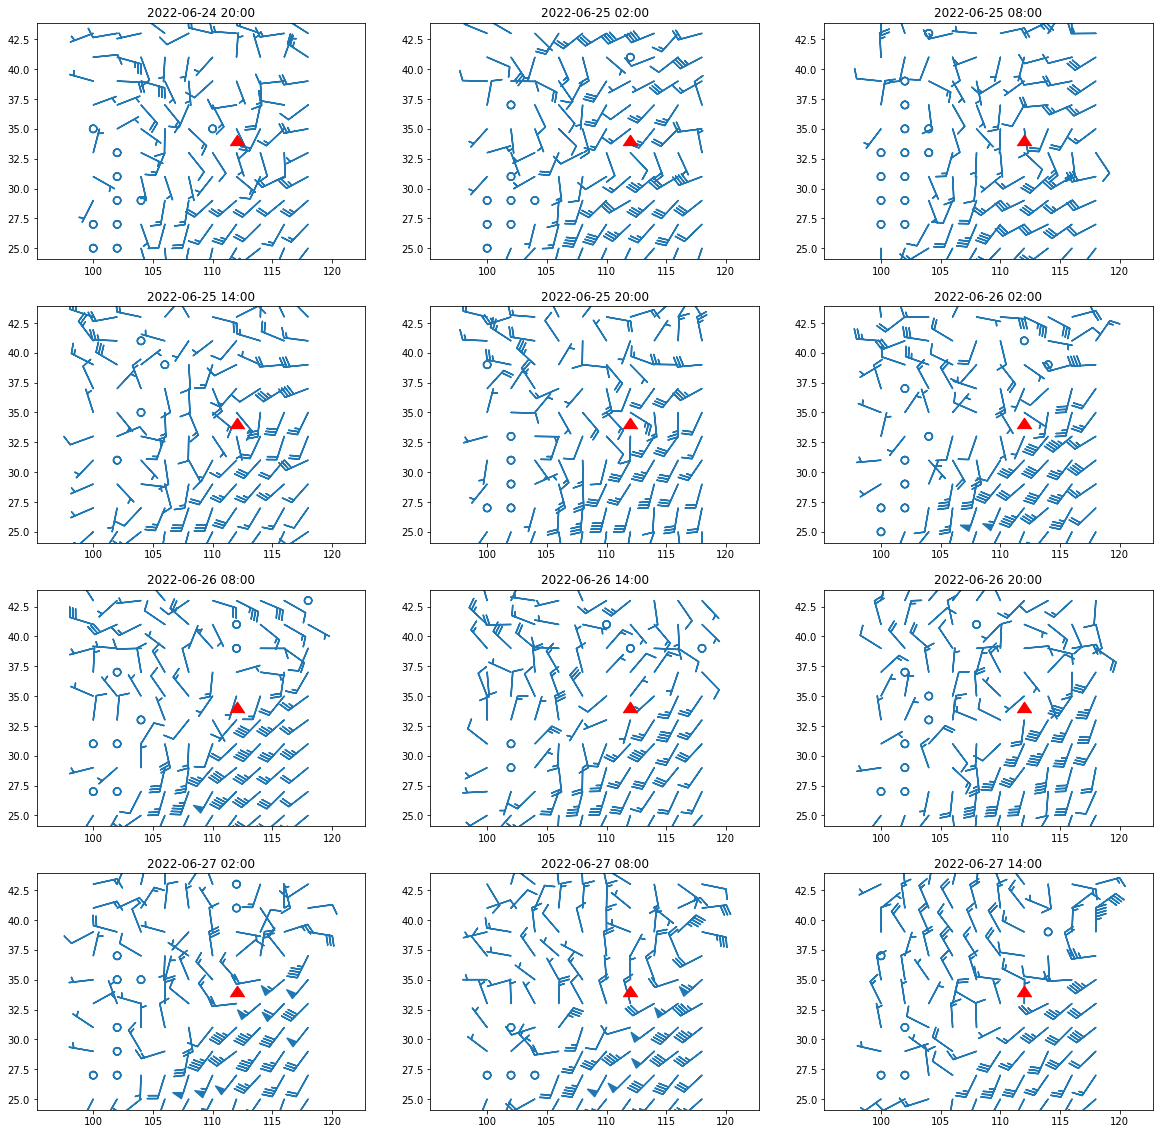

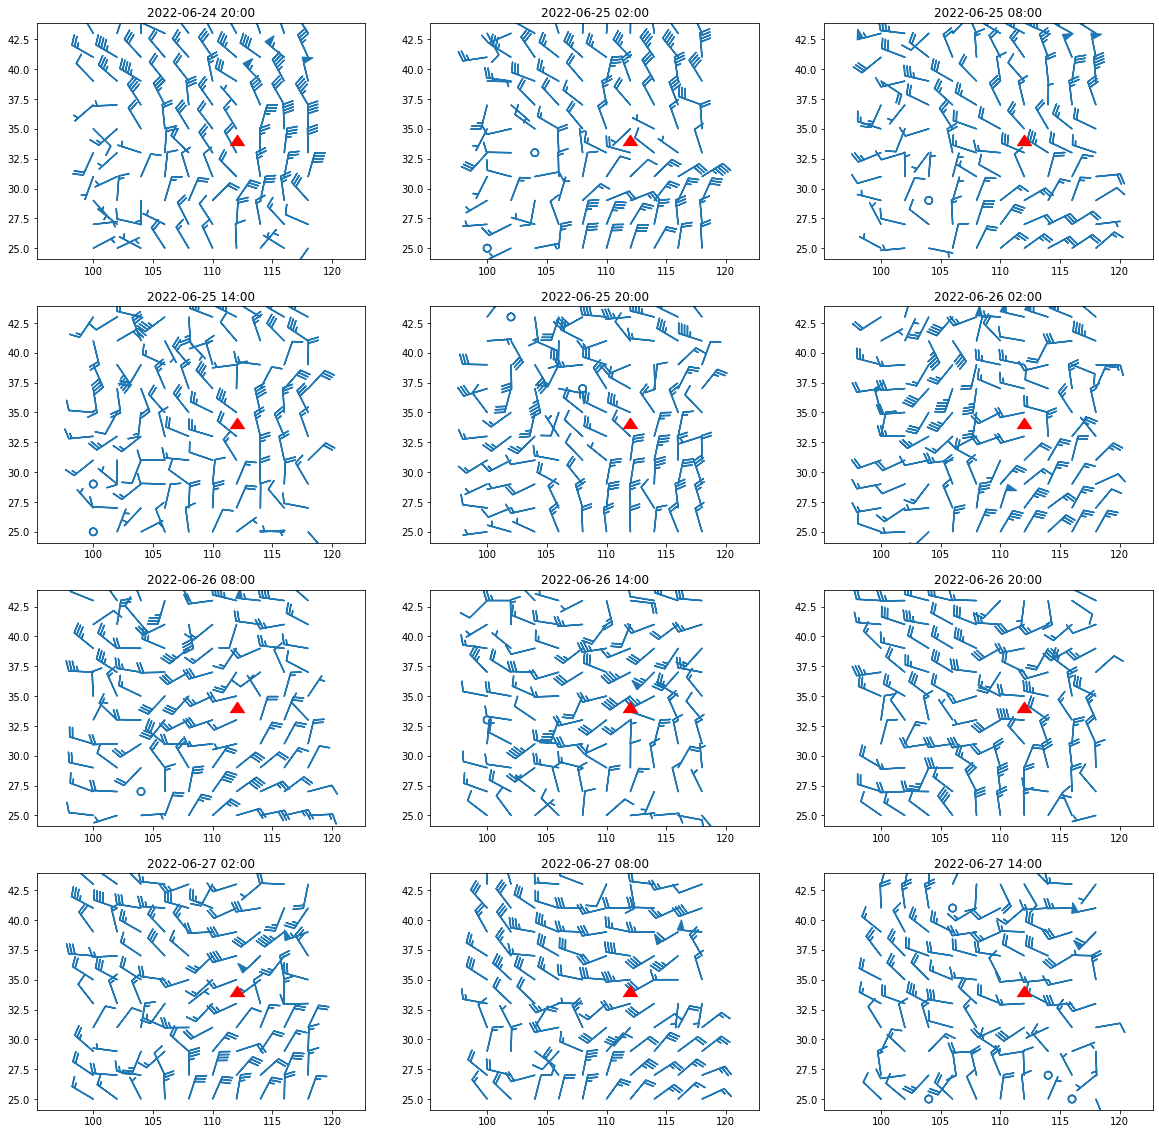

In [121]:
# 绘制图像
left = 100
right=120
top = 45
bottom = 25

def getUVarray(Wind):
    """ getUV from xarray.Dataset alone time
    return array of xarray.DataFrame """
    
    total_size = Wind.sizes['time']

    U = []
    V = []
    for index in range(0, total_size):
        latestEC = Wind.isel(time=index)

        angle = (270 - latestEC.angle) * np.pi / 180

        U.append( latestEC.speed * np.cos(angle) )
        V.append( latestEC.speed * np.sin(angle) )

    return (U, V)

grid_span = 2
Wind850 = Wind850.isel(level=0).sel(lon=np.arange(left,right,grid_span),lat=np.arange(bottom,top,grid_span), method="nearest")
figsize=(20, 20)

def plot_wind(windU, windV, figsize=figsize, total_col = 3):

    fig = plt.figure(figsize=figsize)

    total_size = len(windU)

    total_row = math.ceil(total_size/total_col)

    index = 0
    for row in range(0,total_row):
        for col in range(0, total_col):
            if index >= total_size:
                break

            U = windU[index]
            V = windV[index]
            
            ax = fig.add_subplot(total_row,total_col, index+1)

            title = U.coords['time'].dt.strftime("%Y-%m-%d %H:%M").to_numpy()
            
            ax.set_title(title)
            ax.barbs(U.lon, U.lat, U, V, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
            
            ax.axis('equal')
            ax.scatter(112, 34.5, s=200, c='red', marker=6)

            index = index + 1

U850, V850 = getUVarray(Wind850)
plot_wind(U850, V850)

Wind500 = Wind500.isel(level=0).sel(lon=np.arange(left,right,grid_span),lat=np.arange(bottom,top,grid_span), method="nearest")
U500, V500 = getUVarray(Wind500)

U500_800 = [U500[i] - U850[i] for i in range(0, len(U500))]
V500_800 = [V500[i] - V850[i] for i in range(0, len(V500))]

plot_wind(U500_800, V500_800)

## 1.2 High Wind Plot

In [122]:
level = '700'


In [123]:
plot850 = get_station_data(f"UPPER_AIR/PLOT/{level}", "20220625080000.000", dropna=True, cache=False)

plot850 = plot850.dropna(how='any')
plot850 = plot850[(bottom <= plot850['lat']) & (plot850['lat'] <= top) &
                    (left <= plot850['lon']) & (plot850['lon'] <= right)]
                    
plot850

,ID,lon,lat,Alt,Dewpoint_depression,Geopotential_hight,Temp,Wind_angle,Wind_speed,time
17,52267,101.059998,41.959999,940.200012,23.100000,306.899994,16.400000,289.0,2.6,2022-06-25 08:00:00
22,58424,116.970001,30.620001,63.200001,6.800000,312.200012,11.800000,265.0,7.0,2022-06-25 08:00:00
32,53336,108.510002,41.570000,1289.599976,26.700001,306.500000,16.200001,267.0,5.4,2022-06-25 08:00:00
41,57447,109.470001,30.290001,455.600006,0.500000,309.799988,11.600000,221.0,7.4,2022-06-25 08:00:00
47,57461,111.360001,30.740000,257.700012,4.200000,308.500000,10.600000,231.0,6.6,2022-06-25 08:00:00
52,54401,114.919998,40.770000,774.000000,20.000000,306.100006,14.500000,304.0,11.9,2022-06-25 08:00:00
60,57494,114.050003,30.600000,23.600000,3.100000,310.700012,11.400000,240.0,9.3,2022-06-25 08:00:00
70,57516,106.400002,29.600000,542.099976,3.400000,307.899994,13.100000,219.0,10.4,2022-06-25 08:00:00
71,56492,104.610001,28.770000,504.000000,3.000000,308.200012,14.000000,216.0,5.9,2022-06-25 08:00:00
86,53463,111.570000,40.860001,1154.699951,23.900000,307.500000,14.800000,282.0,5.3,2022-06-25 08:00:00


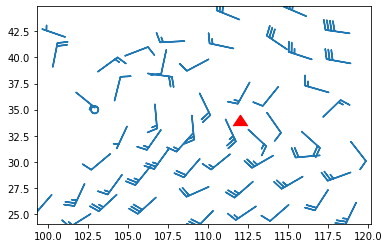

In [124]:
# plot:
angle = (270 - plot850.Wind_angle) * np.pi / 180

U = plot850.Wind_speed * np.cos(angle)
V = plot850.Wind_speed * np.sin(angle)

# plot:
fig, ax = plt.subplots()

wb = ax.barbs(plot850.lon, plot850.lat, U, V, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)

# ax.set(xlim=(0, 4.5), ylim=(0, 4.5))


ax.scatter(112, 34.5, s=200, c='red', marker=6)

# fig.colorbar(wb, ax=ax)

In [125]:
plot850[plot850['ID']==57083]
plot850

,ID,lon,lat,Alt,Dewpoint_depression,Geopotential_hight,Temp,Wind_angle,Wind_speed,time
17,52267,101.059998,41.959999,940.200012,23.100000,306.899994,16.400000,289.0,2.6,2022-06-25 08:00:00
22,58424,116.970001,30.620001,63.200001,6.800000,312.200012,11.800000,265.0,7.0,2022-06-25 08:00:00
32,53336,108.510002,41.570000,1289.599976,26.700001,306.500000,16.200001,267.0,5.4,2022-06-25 08:00:00
41,57447,109.470001,30.290001,455.600006,0.500000,309.799988,11.600000,221.0,7.4,2022-06-25 08:00:00
47,57461,111.360001,30.740000,257.700012,4.200000,308.500000,10.600000,231.0,6.6,2022-06-25 08:00:00
52,54401,114.919998,40.770000,774.000000,20.000000,306.100006,14.500000,304.0,11.9,2022-06-25 08:00:00
60,57494,114.050003,30.600000,23.600000,3.100000,310.700012,11.400000,240.0,9.3,2022-06-25 08:00:00
70,57516,106.400002,29.600000,542.099976,3.400000,307.899994,13.100000,219.0,10.4,2022-06-25 08:00:00
71,56492,104.610001,28.770000,504.000000,3.000000,308.200012,14.000000,216.0,5.9,2022-06-25 08:00:00
86,53463,111.570000,40.860001,1154.699951,23.900000,307.500000,14.800000,282.0,5.3,2022-06-25 08:00:00


## 1.3 Draw Wind Diff

In [126]:
dti = pd.date_range("2022-06-24 20:00", periods=6, freq="-12H").to_series()

filenames = dti.dt.strftime("%y%m%d%H")


directory850 = f"ECMWF_HR/WIND/{level}"
fhours = np.arange(12, 12*7, 12)
filenames = filenames + '.' + ['%03d'%(fhour) for fhour in fhours]

print(filenames)

Wind850 = get_model_grids(directory850, filenames, varname='WIND', varattrs={'long_name':'850hPa Wind', 'units':'m/s'}, cache=False)

Wind850

2022-06-24 20:00:00    22062420.012
2022-06-24 08:00:00    22062408.024
2022-06-23 20:00:00    22062320.036
2022-06-23 08:00:00    22062308.048
2022-06-22 20:00:00    22062220.060
2022-06-22 08:00:00    22062208.072
Freq: -12H, dtype: object


<xarray.Dataset>
Dimensions:                  (time: 6, level: 1, lat: 281, lon: 361)
Coordinates:
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
  * lat                      (lat) float64 -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * level                    (level) float32 700.0
  * time                     (time) datetime64[ns] 2022-06-25T08:00:00 ... 20...
    forecast_reference_time  (time) datetime64[ns] 2022-06-24T20:00:00 ... 20...
    forecast_period          (time) float64 12.0 24.0 36.0 48.0 60.0 72.0
Data variables:
    speed                    (time, level, lat, lon) float32 10.83 ... 8.357
    angle                    (time, level, lat, lon) float32 87.09 ... 315.0
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will rai

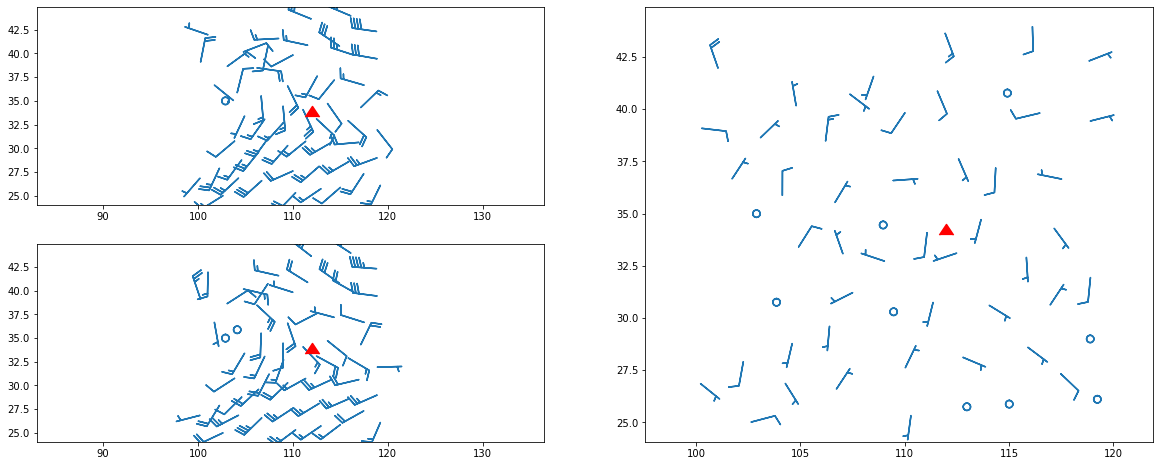

In [127]:
latestEC = Wind850.isel(time=0).isel(level=0)

angle = (270 - latestEC.angle) * np.pi / 180

ecU = latestEC.speed * np.cos(angle)
ecV = latestEC.speed * np.sin(angle)

#print(ecU.interp(lon=112,lat=34.5).item())

interpU = []
interpV = []
for index in range(0, plot850.shape[0]):
    item = plot850[index:index+1]
    interpU.append(ecU.interp(lon=item.lon,lat=item.lat).item())
    interpV.append(ecV.interp(lon=item.lon,lat=item.lat).item())

#print(U - interpU)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.barbs(plot850.lon, plot850.lat, U, V, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
ax0.axis('equal')

ax1 = fig.add_subplot(gs[1, 0])
ax1.barbs(plot850.lon, plot850.lat, interpU, interpV, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
ax1.axis('equal')

ax2 = fig.add_subplot(gs[:, 1])
wb = ax2.barbs(plot850.lon, plot850.lat, U - interpU, V - interpV, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
# ax.set(xlim=(0, 4.5), ylim=(0, 4.5))
ax2.axis('equal')

ax0.scatter(112, 34.5, s=200, c='red', marker=6)
ax1.scatter(112, 34.5, s=200, c='red', marker=6)
ax2.scatter(112, 34.5, s=200, c='red', marker=6)

# fig.colorbar(wb, ax=ax)